## **CNN para classificação multiclasse de imagens**
**Dataset CIFAR-10 (Canadian Institute For Advanced Research)**
- Dataset de imagens
- 60k imagens de cor com 32x32 pixeis classificadas em 10 classes diferentes
- Classes: aviões, carros, aves, gatos, veados, rãs, cavalos, navios e camiões
- 6k por cada classe
- 5k imagens são usadas para treino e 1k para teste

Vamos utilizar uma rede neuronal convolucional para classificação das imagens numa das classes.

## imports

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from PIL import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
import torch.nn as nn
from torch.nn import BatchNorm2d
from torch.nn import Dropout2d
from torch.nn import Sequential
from torch.nn import Linear
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
 
import torchvision.transforms as transforms
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchinfo import summary

from livelossplot import PlotLosses

np.random.seed(0) 
torch.manual_seed(0)
import random
random.seed(0)

# Preparar o setup
Irá ser criada uma estrutura de diretorias em que em [train] temos as images para treino e em [test] as imagens para teste.
O ficheiro "labels.txt" tem as classes enumeradas. A classe a que cada imagem pertence está no nome do ficheiro.

In [2]:
PATH = 'cifar/'
PATH_CLASSES = 'cifar/labels.txt'
PATH_TRAIN = 'cifar/train'
PATH_TEST = 'cifar/test'

BATCH_SIZE = 128

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
         for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

device = get_default_device()
print(device)

cuda


## 1. Preparar os Dados

In [4]:
def get_classes(path):
    with open("cifar/labels.txt") as fich_labels:
        labels = fich_labels.read().split()
        classes = dict(zip(labels, list(range(len(labels)))))
    return classes
dic_classes=get_classes(PATH_CLASSES)
print(dic_classes)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


In [5]:
import os
import random
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torch

# Your preprocessing function
def preprocessar(imagem):
    imagem = np.array(imagem)
    cifar_mean = np.array([0.4914, 0.4822, 0.4465]).reshape(1, 1, -1)
    cifar_std = np.array([0.2023, 0.1994, 0.2010]).reshape(1, 1, -1)
    imagem = (imagem - cifar_mean) / cifar_std
    xmax, xmin = imagem.max(), imagem.min()
    imagem = (imagem - xmin) / (xmax - xmin)
    imagem = imagem.transpose(2, 1, 0)  # (H, W, C) -> (C, W, H)
    return imagem

class Cifar10Dataset(Dataset):

    def __init__(self, path, mun_imagens=0, transforms=None):
        files = os.listdir(path)
        files = [os.path.join(path, f) for f in files if f.endswith((".png", ".jpg", ".jpeg"))]
        if mun_imagens == 0:
            mun_imagens = len(files)
        self.mun_imagens = mun_imagens
        self.transforms = transforms

        selected_files = random.sample(files, self.mun_imagens)

        # Load and store all images + labels in memory
        self.imagens = []
        self.labels = []

        for f in selected_files:
            img = Image.open(f).convert("RGB")
            img = preprocessar(img).astype(np.float32)
            label_str = f[:-4].split("_")[-1]
            label = dic_classes[label_str]
            self.imagens.append(img)
            self.labels.append(label)

        # Convert to NumPy arrays for fast access
        self.imagens = np.stack(self.imagens)
        self.labels = np.array(self.labels)

    def __len__(self):
        return self.mun_imagens

    def __getitem__(self, idx):
        imagem = self.imagens[idx]
        label = self.labels[idx]
        if self.transforms:
            imagem = self.transforms(imagem)
        return imagem, label

def prepare_data_loaders(path_train, path_test):
    dataset_train = Cifar10Dataset(path_train,transforms=None)
    dataset_test = Cifar10Dataset(path_test,transforms=None)
    
    train_size = int(0.8 * len(dataset_train))
    val_size = len(dataset_train) - train_size
    train, validation = random_split(dataset_train, [train_size, val_size], generator=torch.Generator().manual_seed(42))
    
    train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(validation, batch_size=BATCH_SIZE, shuffle=True)
    test_dl = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=True)
    val_dl_all = DataLoader(validation, batch_size=len(validation), shuffle=True)
    test_dl_all = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=True)
    return train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all

train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all = prepare_data_loaders(PATH_TRAIN, PATH_TEST)

## 1.1 Visualizar os Dados

In [6]:
def output_label(label,mapping='label'):
    if mapping == 'ext':
        output_mapping = { 0:"zero", 1:"um", 2:"dois", 3:"tres", 4:"quatro", 5:"cinco", 6:"seis", 7:"sete", 8:"oito", 9:"nove" }
    elif mapping == 'ext2':
        output_mapping = { "0":"zero", "1":"um", "2":"dois", "3":"tres", "4":"quatro", "5":"cinco", "6":"seis", "7":"sete", "8":"oito", "9":"nove" }
    else:
        output_mapping = { 0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9"}
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [7]:
from IPython.display import display

def visualize_data(path):
    df = pd.read_csv(path, header=0)
    display(df)

def visualize_dataset(train_dl, test_dl, dataset_train, dataset_test):
    print(f"Quantidade de casos de Treino:{len(train_dl.dataset)}") 
    print(f"Quantidade de casos de Validação:{len(val_dl.dataset)}")
    print(f"Quantidade de casos de Teste:{len(test_dl.dataset)}")
    
    x, y = next(iter(train_dl))
    print(f"Shape tensor batch casos treino, input: {x.shape}, output: {y.shape}")
    x, y = next(iter(val_dl))
    print(f"Shape tensor batch casos validação, input: {x.shape}, output: {y.shape}")
    x, y = next(iter(test_dl))  
    print(f"Shape tensor batch casos test, input: {x.shape}, output: {y.shape}")
    
    print(f'Valor maximo:{torch.max(x)} Valor mínimo:{torch.min(x)}')
    x=x.detach().numpy()
    print(f'Valor maximo:{np.max(x)} Valor mínimo:{np.min(x)}')
    print(y)
    
visualize_dataset(train_dl, test_dl, train_dl_all, test_dl_all)

Quantidade de casos de Treino:40000
Quantidade de casos de Validação:10000
Quantidade de casos de Teste:10000
Shape tensor batch casos treino, input: torch.Size([128, 3, 32, 32]), output: torch.Size([128])
Shape tensor batch casos validação, input: torch.Size([128, 3, 32, 32]), output: torch.Size([128])
Shape tensor batch casos test, input: torch.Size([128, 3, 32, 32]), output: torch.Size([128])
Valor maximo:1.0 Valor mínimo:0.0
Valor maximo:1.0 Valor mínimo:0.0
tensor([2, 4, 0, 5, 8, 7, 8, 0, 9, 5, 2, 0, 5, 2, 0, 1, 4, 2, 6, 4, 8, 2, 9, 0,
        0, 9, 6, 4, 5, 2, 4, 4, 1, 3, 1, 9, 1, 5, 8, 5, 8, 5, 5, 2, 2, 1, 5, 8,
        8, 7, 0, 2, 6, 5, 9, 3, 4, 8, 5, 4, 3, 2, 9, 8, 4, 5, 4, 2, 9, 4, 1, 3,
        4, 8, 6, 2, 2, 8, 8, 3, 3, 8, 3, 8, 6, 0, 6, 9, 6, 5, 8, 4, 4, 0, 4, 3,
        5, 7, 1, 5, 7, 4, 9, 3, 3, 2, 9, 5, 5, 2, 2, 1, 2, 7, 6, 7, 6, 8, 2, 2,
        1, 0, 6, 6, 6, 1, 7, 4])


torch.Size([128, 3, 32, 32])


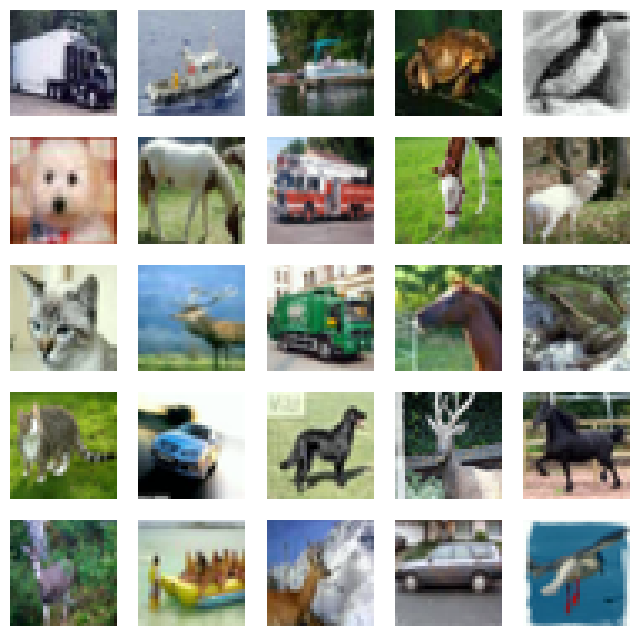

In [8]:
def visualize_images(dl):
    i, (inputs, targets) = next(enumerate(dl))
    print(inputs.shape)
    plt.figure(figsize=(8,8))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.axis('off')
        plt.grid()
        imagem = inputs[i]
        plt.imshow(imagem.permute((2, 1, 0)))
    plt.show()

visualize_images(train_dl)

## 1.2 Verificar balanceamento do dataset

-----------------------------------casos_treino-----------------------------------
casos: 40000
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
[4001 4006 4053 3976 4012 3965 4030 3947 4015 3995]
40000


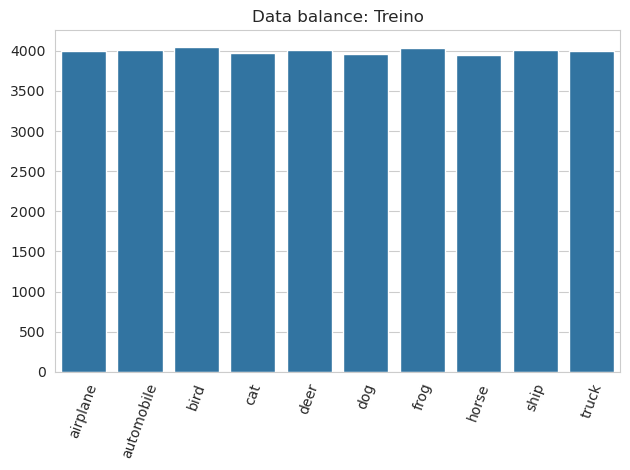

-----------------------------------casos_validação-----------------------------------
casos: 10000
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
[ 999  994  947 1024  988 1035  970 1053  985 1005]
10000


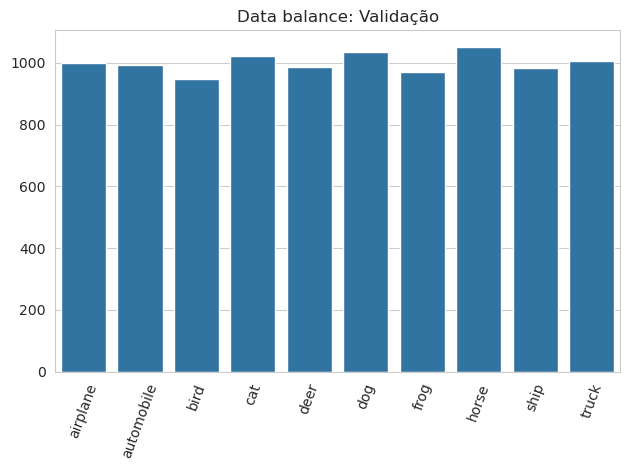

-----------------------------------casos_teste-----------------------------------
casos: 10000
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]
10000


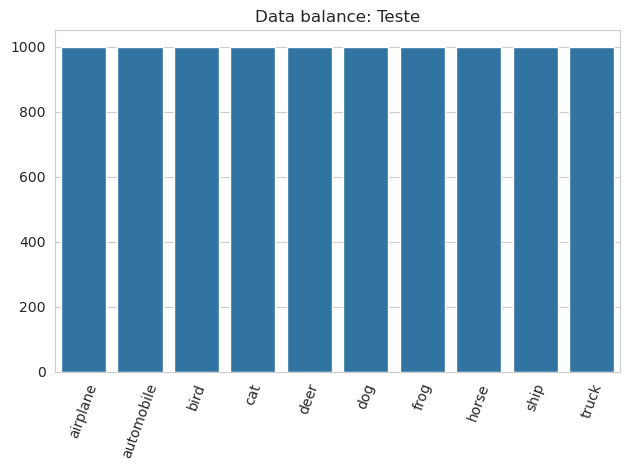

In [9]:
import seaborn as sns

def visualize_holdout_balance(dl, titulo):
    _, labels = next(iter(dl))                            
    sns.set_style('whitegrid')
    print("casos:",len(labels))
    x, y = np.unique(labels, return_counts=True)
    x_ext=[list(dic_classes.keys())[n] for n in x]
    print([str(n)  for n in x])
    print(y)
    print(np.sum(y))
    grafico=sns.barplot(x=x_ext,y=y)
    grafico.set_title(f'Data balance: {titulo}')
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show() 
    
print("-----------------------------------casos_treino-----------------------------------")   
visualize_holdout_balance(train_dl_all, 'Treino')
print("-----------------------------------casos_validação-----------------------------------")   
visualize_holdout_balance(val_dl_all, 'Validação')
print("-----------------------------------casos_teste-----------------------------------") 
visualize_holdout_balance(test_dl_all, 'Teste')

## 2. Definir o Modelo

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,kernel_size=(3, 3), stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels,kernel_size=(3, 3), stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels,kernel_size=(1, 1), stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out

class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3),stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.block1 = self._create_block(64, 64, stride=1)
        self.block2 = self._create_block(64, 128, stride=2)
        self.block3 = self._create_block(128, 256, stride=2)
        self.block4 = self._create_block(256, 512, stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _create_block(self, in_channels, out_channels, stride):
        return nn.Sequential(
            ResidualBlock(in_channels, out_channels, stride),
            ResidualBlock(out_channels, out_channels, 1)
        )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = nn.AvgPool2d(4)(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
model = ResNet()
print(summary(model, input_size=(BATCH_SIZE, 3,32,32), verbose=0))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 10]                 --
├─Conv2d: 1-1                            [128, 64, 32, 32]         1,728
├─BatchNorm2d: 1-2                       [128, 64, 32, 32]         128
├─Sequential: 1-3                        [128, 64, 32, 32]         --
│    └─ResidualBlock: 2-1                [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-2             [128, 64, 32, 32]         128
│    │    └─Conv2d: 3-3                  [128, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-4             [128, 64, 32, 32]         128
│    │    └─Sequential: 3-5              [128, 64, 32, 32]         --
│    └─ResidualBlock: 2-2                [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-6                  [128, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-7             [128, 64, 32, 32]         

In [11]:
class CNNModel_1(Module):
    def __init__(self):
        super(CNNModel_1, self).__init__()
        self.layer1 = Sequential(Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3)),
                                 ReLU(),
                                 MaxPool2d(kernel_size=(2,2), stride=(2,2))           
                                )
        self.layer2 = Sequential(Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3)),
                                 ReLU(),
                                 MaxPool2d(kernel_size=(2,2), stride=(2,2))           
                                )
        self.fc1 = Linear(in_features=6*6*32, out_features=100)
        kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        self.fc2 = Linear(in_features=100, out_features=10)
        xavier_uniform_(self.fc2.weight)
        self.act2 = Softmax(dim=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(-1, 6*6*32)
        out = self.fc1(out)
        out = self.act1(out)
        out = self.fc2(out) 
        out = self.act2(out)
        return out

model = CNNModel_1()
print(summary(model, input_size=(BATCH_SIZE, 3,32,32), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_1                               [128, 10]                 --
├─Sequential: 1-1                        [128, 32, 15, 15]         --
│    └─Conv2d: 2-1                       [128, 32, 30, 30]         896
│    └─ReLU: 2-2                         [128, 32, 30, 30]         --
│    └─MaxPool2d: 2-3                    [128, 32, 15, 15]         --
├─Sequential: 1-2                        [128, 32, 6, 6]           --
│    └─Conv2d: 2-4                       [128, 32, 13, 13]         9,248
│    └─ReLU: 2-5                         [128, 32, 13, 13]         --
│    └─MaxPool2d: 2-6                    [128, 32, 6, 6]           --
├─Linear: 1-3                            [128, 100]                115,300
├─ReLU: 1-4                              [128, 100]                --
├─Linear: 1-5                            [128, 10]                 1,010
├─Softmax: 1-6                           [128, 10]                 --
Tot

CNNModel_1(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1152, out_features=100, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (act2): Softmax(dim=1)
)

In [12]:
class CNNModel_2(Module):
    def __init__(self):
        super(CNNModel_2, self).__init__()
        self.layer1 = Sequential(Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=0),
                                 ReLU(),
                                 MaxPool2d(kernel_size=2)
                                )
        self.layer2 = Sequential(Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0),
                                 ReLU(),
                                 MaxPool2d(kernel_size=2)
                                )       
        self.fc1 = Linear(32 * 6 * 6, 10)  
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) 
        out = self.fc1(out) 
        return out
    
model = CNNModel_2()
print(summary(model, input_size=(BATCH_SIZE, 3,32,32), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_2                               [128, 10]                 --
├─Sequential: 1-1                        [128, 16, 15, 15]         --
│    └─Conv2d: 2-1                       [128, 16, 30, 30]         448
│    └─ReLU: 2-2                         [128, 16, 30, 30]         --
│    └─MaxPool2d: 2-3                    [128, 16, 15, 15]         --
├─Sequential: 1-2                        [128, 32, 6, 6]           --
│    └─Conv2d: 2-4                       [128, 32, 13, 13]         4,640
│    └─ReLU: 2-5                         [128, 32, 13, 13]         --
│    └─MaxPool2d: 2-6                    [128, 32, 6, 6]           --
├─Linear: 1-3                            [128, 10]                 11,530
Total params: 16,618
Trainable params: 16,618
Non-trainable params: 0
Total mult-adds (M): 153.46
Input size (MB): 1.57
Forward/backward pass size (MB): 20.29
Params size (MB): 0.07
Estimated Total Size (MB): 21.93


CNNModel_2(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1152, out_features=10, bias=True)
)

In [13]:
class CNNModel_3(Module):
    def __init__(self):
        super(CNNModel_3, self).__init__()
        self.layer1 = nn.Sequential(Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
                                    BatchNorm2d(32),
                                    ReLU(),
                                    MaxPool2d(kernel_size=2, stride=2)
                                    )
        self.layer2 = nn.Sequential(Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                                    BatchNorm2d(64),
                                    ReLU(),
                                    MaxPool2d(2)
                                    )
        self.fc1 = Linear(in_features=64*7*7, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = Linear(in_features=600, out_features=120)
        self.fc3 = Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out
    
model = CNNModel_3()
print(summary(model, input_size=(BATCH_SIZE, 3,32,32), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_3                               [128, 10]                 --
├─Sequential: 1-1                        [128, 32, 16, 16]         --
│    └─Conv2d: 2-1                       [128, 32, 32, 32]         896
│    └─BatchNorm2d: 2-2                  [128, 32, 32, 32]         64
│    └─ReLU: 2-3                         [128, 32, 32, 32]         --
│    └─MaxPool2d: 2-4                    [128, 32, 16, 16]         --
├─Sequential: 1-2                        [128, 64, 7, 7]           --
│    └─Conv2d: 2-5                       [128, 64, 14, 14]         18,496
│    └─BatchNorm2d: 2-6                  [128, 64, 14, 14]         128
│    └─ReLU: 2-7                         [128, 64, 14, 14]         --
│    └─MaxPool2d: 2-8                    [128, 64, 7, 7]           --
├─Linear: 1-3                            [128, 600]                1,882,200
├─Dropout2d: 1-4                         [128, 600]                --
├─

/home/eduardo/miniconda3/envs/env/lib/python3.10/site-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


CNNModel_3(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=3136, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)

In [14]:
class CNNModel_4(Module):
    def __init__(self):
        super(CNNModel_4, self).__init__()
        self.layer1 = Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=0),
                                    BatchNorm2d(32),
                                    ReLU(),
                                    MaxPool2d(2),
                                    Dropout2d(0.2)
                                    )
        self.fc1 = Linear(in_features=32*14*14, out_features=128)
        self.fc2 = Linear(in_features=128, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    

model = CNNModel_4()
print(summary(model, input_size=(BATCH_SIZE, 3,32,32), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_4                               [128, 10]                 --
├─Sequential: 1-1                        [128, 32, 14, 14]         --
│    └─Conv2d: 2-1                       [128, 32, 28, 28]         2,432
│    └─BatchNorm2d: 2-2                  [128, 32, 28, 28]         64
│    └─ReLU: 2-3                         [128, 32, 28, 28]         --
│    └─MaxPool2d: 2-4                    [128, 32, 14, 14]         --
│    └─Dropout2d: 2-5                    [128, 32, 14, 14]         --
├─Linear: 1-2                            [128, 128]                802,944
├─Linear: 1-3                            [128, 10]                 1,290
Total params: 806,730
Trainable params: 806,730
Non-trainable params: 0
Total mult-adds (M): 347.01
Input size (MB): 1.57
Forward/backward pass size (MB): 51.52
Params size (MB): 3.23
Estimated Total Size (MB): 56.32


CNNModel_4(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.2, inplace=False)
  )
  (fc1): Linear(in_features=6272, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

## 3. Treinar o Modelo

In [15]:
def train_model(h5_file, train_dl, val_dl, model, criterion, optimizer):
    liveloss = PlotLosses()
    for epoch in range(EPOCHS):
        logs = {}
        model.train() 
        running_loss  = 0.0
        running_corrects  = 0.0
        for batch_i, (inputs, labels) in enumerate(train_dl): 
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1) 
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_dl.dataset)
        epoch_acc = running_corrects.float() / len(train_dl.dataset)
        logs['loss'] = epoch_loss.item()
        logs['accuracy'] = epoch_acc.item()
            
        model.eval()
        running_loss  = 0.0
        running_corrects  = 0.0
        for inputs, labels in val_dl: 
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1) 
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(val_dl.dataset)
        epoch_acc = running_corrects.float() / len(val_dl.dataset)
        logs['val_loss'] = epoch_loss.item()
        logs['val_accuracy'] = epoch_acc.item()     
        liveloss.update(logs)
        liveloss.send()
    torch.save(model,h5_file)

In [16]:
######### ResNet ################
model = ResNet()
print(summary(model, input_size=(BATCH_SIZE, 3,32,32), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 10]                 --
├─Conv2d: 1-1                            [128, 64, 32, 32]         1,728
├─BatchNorm2d: 1-2                       [128, 64, 32, 32]         128
├─Sequential: 1-3                        [128, 64, 32, 32]         --
│    └─ResidualBlock: 2-1                [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-2             [128, 64, 32, 32]         128
│    │    └─Conv2d: 3-3                  [128, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-4             [128, 64, 32, 32]         128
│    │    └─Sequential: 3-5              [128, 64, 32, 32]         --
│    └─ResidualBlock: 2-2                [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-6                  [128, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-7             [128, 64, 32, 32]         

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

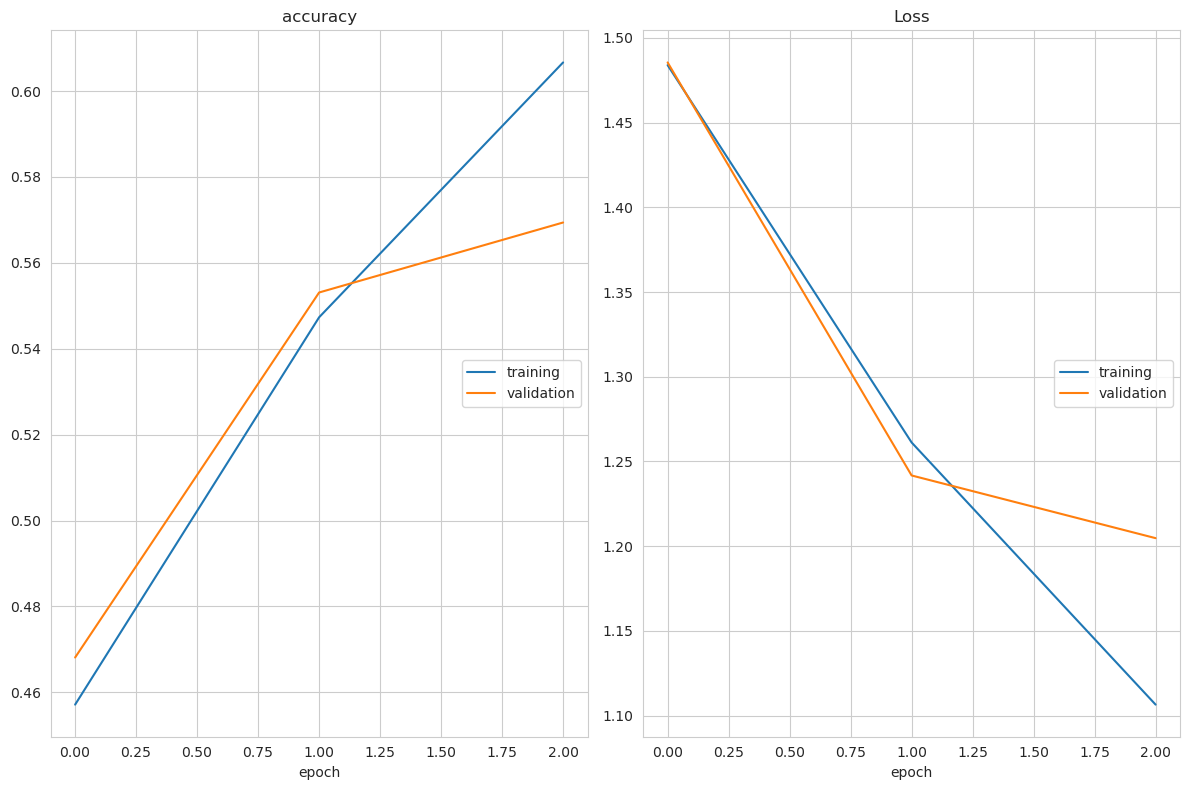

accuracy
	training         	 (min:    0.457, max:    0.607, cur:    0.607)
	validation       	 (min:    0.468, max:    0.569, cur:    0.569)
Loss
	training         	 (min:    1.107, max:    1.484, cur:    1.107)
	validation       	 (min:    1.205, max:    1.486, cur:    1.205)
Tempo gasto: 121.53587130500091 segundos


In [18]:
EPOCHS = 3
LEARNING_RATE = 0.003
criterion = CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel_cifar_Resnet.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

In [19]:
######### CNNModel_1 ################
model = CNNModel_1()
print(summary(model, input_size=(BATCH_SIZE, 3,32,32), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_1                               [128, 10]                 --
├─Sequential: 1-1                        [128, 32, 15, 15]         --
│    └─Conv2d: 2-1                       [128, 32, 30, 30]         896
│    └─ReLU: 2-2                         [128, 32, 30, 30]         --
│    └─MaxPool2d: 2-3                    [128, 32, 15, 15]         --
├─Sequential: 1-2                        [128, 32, 6, 6]           --
│    └─Conv2d: 2-4                       [128, 32, 13, 13]         9,248
│    └─ReLU: 2-5                         [128, 32, 13, 13]         --
│    └─MaxPool2d: 2-6                    [128, 32, 6, 6]           --
├─Linear: 1-3                            [128, 100]                115,300
├─ReLU: 1-4                              [128, 100]                --
├─Linear: 1-5                            [128, 10]                 1,010
├─Softmax: 1-6                           [128, 10]                 --
Tot

CNNModel_1(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1152, out_features=100, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (act2): Softmax(dim=1)
)

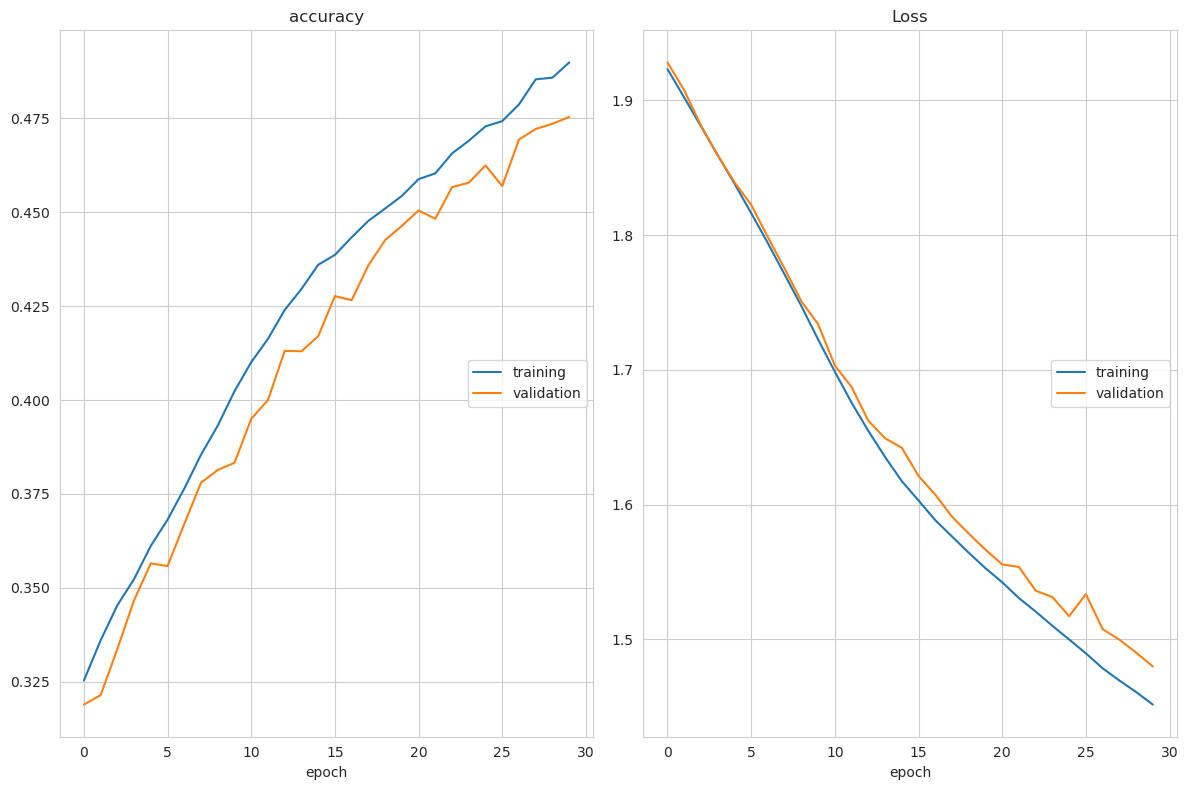

accuracy
	training         	 (min:    0.325, max:    0.490, cur:    0.490)
	validation       	 (min:    0.319, max:    0.475, cur:    0.475)
Loss
	training         	 (min:    1.452, max:    1.923, cur:    1.452)
	validation       	 (min:    1.480, max:    1.928, cur:    1.480)
Tempo gasto: 32.93203350400108 segundos


In [23]:
EPOCHS = 30
LEARNING_RATE = 0.003
criterion = CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel_cifar_1.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

In [21]:
######### CNNModel_2 ################
model = CNNModel_2()
print(summary(model, input_size=(BATCH_SIZE, 3,32,32), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_2                               [128, 10]                 --
├─Sequential: 1-1                        [128, 16, 15, 15]         --
│    └─Conv2d: 2-1                       [128, 16, 30, 30]         448
│    └─ReLU: 2-2                         [128, 16, 30, 30]         --
│    └─MaxPool2d: 2-3                    [128, 16, 15, 15]         --
├─Sequential: 1-2                        [128, 32, 6, 6]           --
│    └─Conv2d: 2-4                       [128, 32, 13, 13]         4,640
│    └─ReLU: 2-5                         [128, 32, 13, 13]         --
│    └─MaxPool2d: 2-6                    [128, 32, 6, 6]           --
├─Linear: 1-3                            [128, 10]                 11,530
Total params: 16,618
Trainable params: 16,618
Non-trainable params: 0
Total mult-adds (M): 153.46
Input size (MB): 1.57
Forward/backward pass size (MB): 20.29
Params size (MB): 0.07
Estimated Total Size (MB): 21.93


CNNModel_2(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1152, out_features=10, bias=True)
)

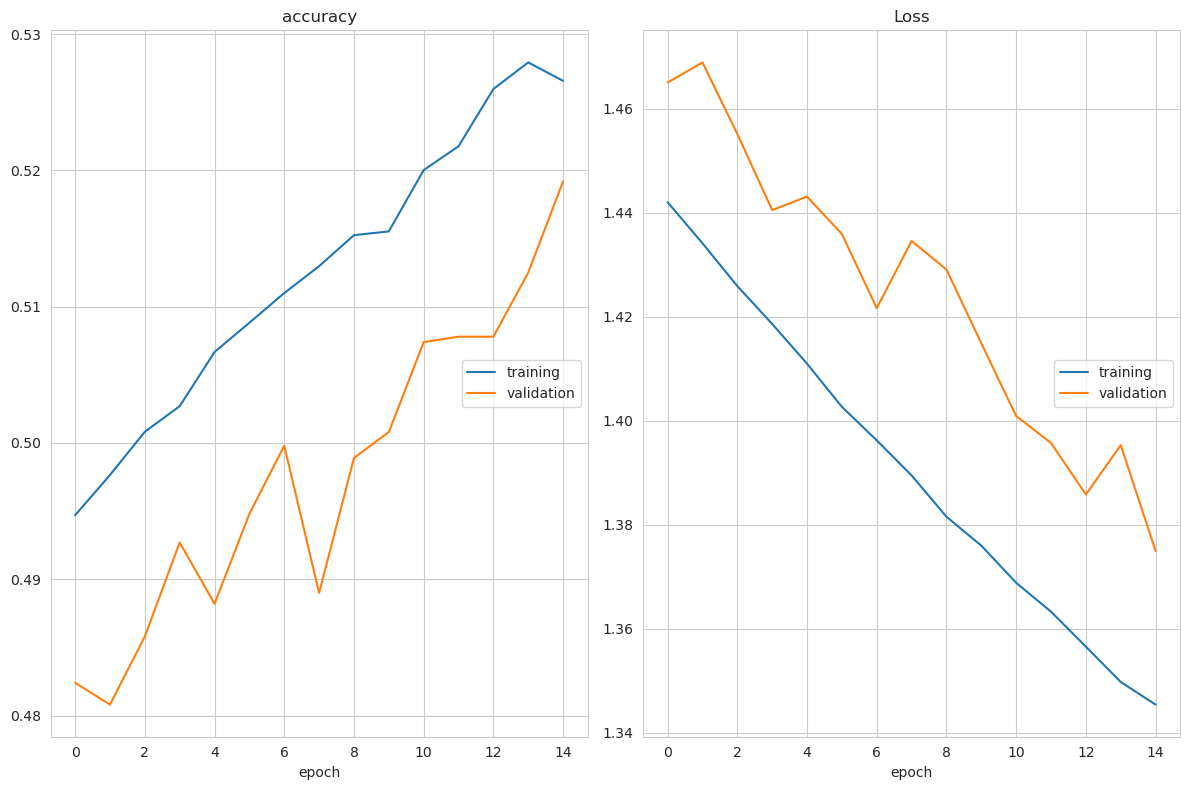

accuracy
	training         	 (min:    0.495, max:    0.528, cur:    0.527)
	validation       	 (min:    0.481, max:    0.519, cur:    0.519)
Loss
	training         	 (min:    1.345, max:    1.442, cur:    1.345)
	validation       	 (min:    1.375, max:    1.469, cur:    1.375)
Tempo gasto: 16.944397156999912 segundos


In [24]:
EPOCHS = 15
LEARNING_RATE = 0.003
criterion = CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel_cifar_2.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

In [25]:
######### CNNModel_3 ################
model = CNNModel_3()
print(summary(model, input_size=(BATCH_SIZE, 3,32,32), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_3                               [128, 10]                 --
├─Sequential: 1-1                        [128, 32, 16, 16]         --
│    └─Conv2d: 2-1                       [128, 32, 32, 32]         896
│    └─BatchNorm2d: 2-2                  [128, 32, 32, 32]         64
│    └─ReLU: 2-3                         [128, 32, 32, 32]         --
│    └─MaxPool2d: 2-4                    [128, 32, 16, 16]         --
├─Sequential: 1-2                        [128, 64, 7, 7]           --
│    └─Conv2d: 2-5                       [128, 64, 14, 14]         18,496
│    └─BatchNorm2d: 2-6                  [128, 64, 14, 14]         128
│    └─ReLU: 2-7                         [128, 64, 14, 14]         --
│    └─MaxPool2d: 2-8                    [128, 64, 7, 7]           --
├─Linear: 1-3                            [128, 600]                1,882,200
├─Dropout2d: 1-4                         [128, 600]                --
├─

CNNModel_3(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=3136, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)

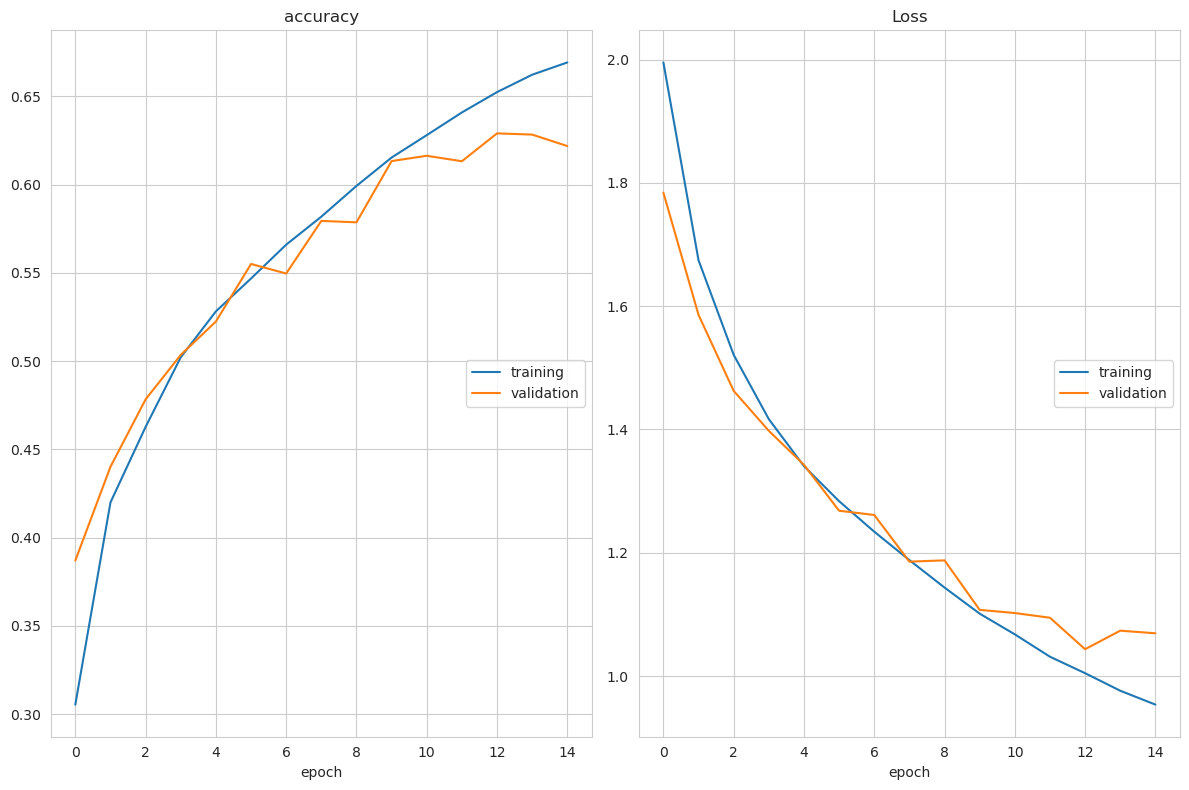

accuracy
	training         	 (min:    0.305, max:    0.669, cur:    0.669)
	validation       	 (min:    0.387, max:    0.629, cur:    0.622)
Loss
	training         	 (min:    0.954, max:    1.995, cur:    0.954)
	validation       	 (min:    1.044, max:    1.784, cur:    1.069)
Tempo gasto: 34.33041891800167 segundos


In [26]:
EPOCHS = 15
LEARNING_RATE = 0.003
criterion = CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel_cifar_3.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

In [27]:
######### CNNModel_4 ################
model = CNNModel_4()
print(summary(model, input_size=(BATCH_SIZE, 3,32,32), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_4                               [128, 10]                 --
├─Sequential: 1-1                        [128, 32, 14, 14]         --
│    └─Conv2d: 2-1                       [128, 32, 28, 28]         2,432
│    └─BatchNorm2d: 2-2                  [128, 32, 28, 28]         64
│    └─ReLU: 2-3                         [128, 32, 28, 28]         --
│    └─MaxPool2d: 2-4                    [128, 32, 14, 14]         --
│    └─Dropout2d: 2-5                    [128, 32, 14, 14]         --
├─Linear: 1-2                            [128, 128]                802,944
├─Linear: 1-3                            [128, 10]                 1,290
Total params: 806,730
Trainable params: 806,730
Non-trainable params: 0
Total mult-adds (M): 347.01
Input size (MB): 1.57
Forward/backward pass size (MB): 51.52
Params size (MB): 3.23
Estimated Total Size (MB): 56.32


CNNModel_4(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.2, inplace=False)
  )
  (fc1): Linear(in_features=6272, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

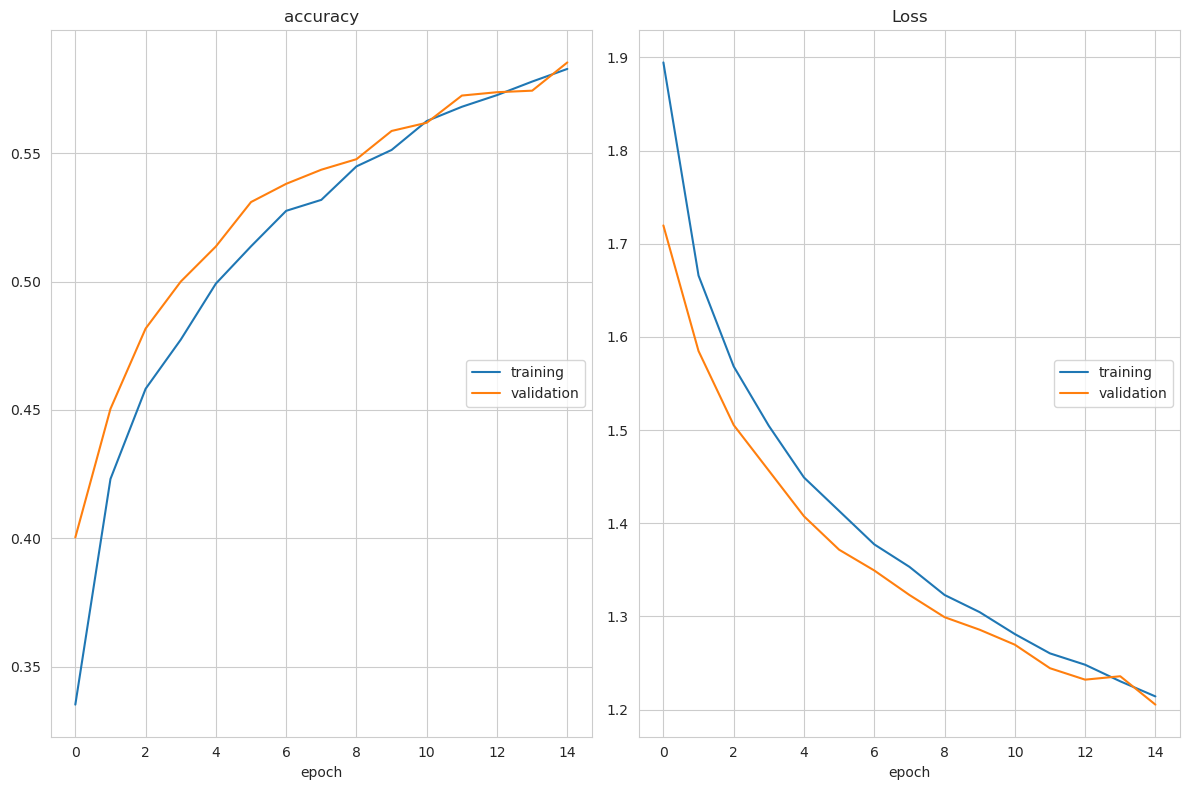

accuracy
	training         	 (min:    0.335, max:    0.583, cur:    0.583)
	validation       	 (min:    0.400, max:    0.585, cur:    0.585)
Loss
	training         	 (min:    1.214, max:    1.895, cur:    1.214)
	validation       	 (min:    1.205, max:    1.720, cur:    1.205)
Tempo gasto: 21.386143457999424 segundos


In [28]:
EPOCHS = 15
LEARNING_RATE = 0.003
criterion = CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel_cifar_4.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

## 4. Avaliar o Modelo

In [29]:
def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    for inputs, labels in test_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)
        yprev = model(inputs)
        yprev = yprev.detach().cpu().numpy()
        actual = labels.cpu().numpy()
        yprev = np.argmax(yprev, axis=1)
        actual = actual.reshape((len(actual), 1))
        yprev = yprev.reshape((len(yprev), 1))
        predictions.append(yprev)
        actual_values.append(actual)
        #break
    predictions, actual_values = np.vstack(predictions), np.vstack(actual_values)
    return actual_values, predictions

def display_predictions(actual_values, predictions ):
    acertou=0
    falhou = 0
    primeiros=0
    for r,p in zip(actual_values, predictions):
        if primeiros <20:
            print(f'real:{r} previsão:{p}') 
            primeiros +=1
        if r==p: acertou+=1  
        else: falhou+=1
    corrects = np.sum(predictions == actual_values)
    acc = corrects / len(test_dl.dataset)
    acc = accuracy_score(actual_values, predictions)
    print(f'Accuracy: {acc:0.3f}\n')
    print(f'acertou:{acertou} falhou:{falhou}')

    acc = accuracy_score(actual_values, predictions)
    print(f'Accuracy: {acc:0.3f}\n')
    print(f'acertou:{acertou} falhou:{falhou}')

def display_confusion_matrix(cm,list_classes):
    plt.figure(figsize = (16,8))
    sns.heatmap(cm,annot=True,xticklabels=list_classes,yticklabels=list_classes, annot_kws={"size": 12}, fmt='g', linewidths=.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show() 
    
model= torch.load('CNNModel_cifar_3.pth',weights_only=False)
actual_values, predictions = evaluate_model(test_dl_all, model)
display_predictions(actual_values, predictions )
print(classification_report(actual_values, predictions))
cr =classification_report(actual_values, predictions, output_dict=True)
list_classes=[output_label(n,'ext2') for n in list(cr.keys())[0:10] ] 
cm = confusion_matrix(actual_values, predictions)

print (cm)
display_confusion_matrix(cm,list_classes)

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.22 GiB. GPU 0 has a total capacity of 3.80 GiB of which 887.44 MiB is free. Including non-PyTorch memory, this process has 2.88 GiB memory in use. Of the allocated memory 2.70 GiB is allocated by PyTorch, and 74.63 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

/home/eduardo/miniconda3/envs/env/lib/python3.10/site-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


real:[4] previsão:[3]
real:[7] previsão:[2]
real:[2] previsão:[8]
real:[3] previsão:[2]
real:[2] previsão:[7]
real:[3] previsão:[5]
real:[6] previsão:[6]
real:[0] previsão:[0]
real:[4] previsão:[4]
real:[4] previsão:[5]
real:[1] previsão:[1]
real:[9] previsão:[9]
real:[8] previsão:[1]
real:[7] previsão:[2]
real:[7] previsão:[7]
real:[1] previsão:[2]
real:[2] previsão:[2]
real:[3] previsão:[6]
real:[5] previsão:[3]
real:[5] previsão:[3]
Accuracy: 0.620

acertou: 6202 falhou: 3798
              precision    recall  f1-score   support

           0       0.63      0.72      0.67      1000
           1       0.66      0.82      0.73      1000
           2       0.50      0.52      0.51      1000
           3       0.48      0.45      0.46      1000
           4       0.66      0.44      0.53      1000
           5       0.58      0.46      0.51      1000
           6       0.53      0.89      0.66      1000
           7       0.87      0.56      0.68      1000
           8       0.67      

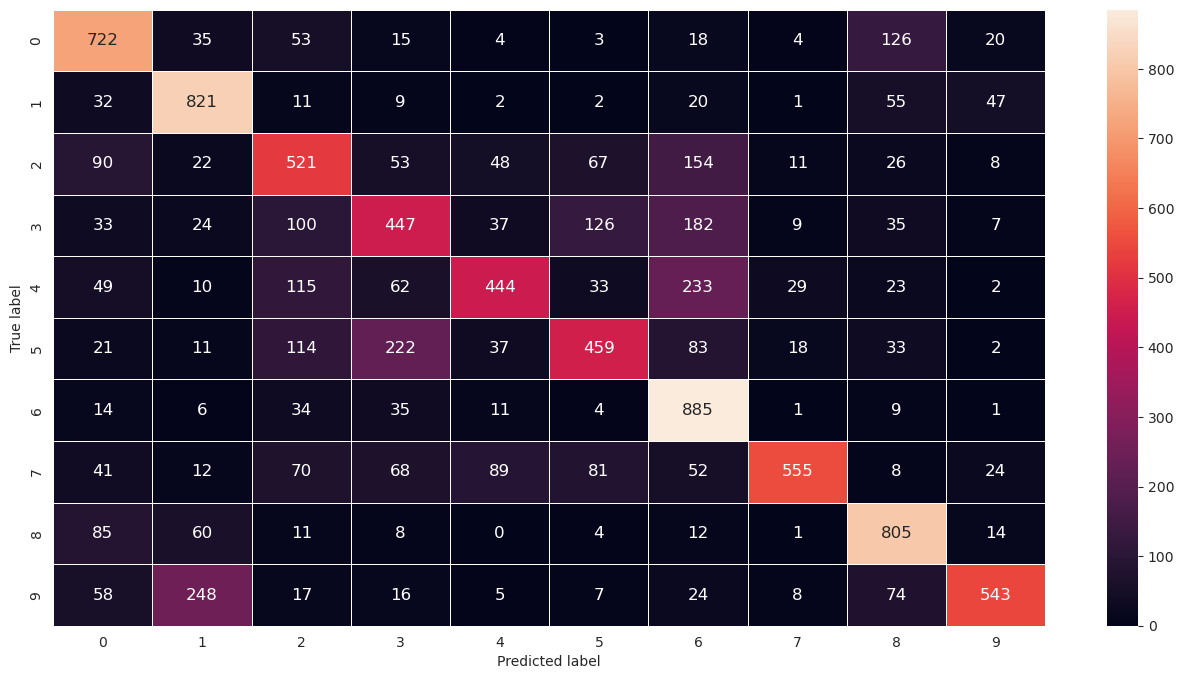

In [31]:
BATCH_SIZE=8

import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    with torch.no_grad():  
        for inputs, labels in test_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)

            yprev = model(inputs)

            yprev = yprev.detach().cpu().numpy()
            actual = labels.cpu().numpy()

            yprev = np.argmax(yprev, axis=1)
            actual = actual.reshape((len(actual), 1))
            yprev = yprev.reshape((len(yprev), 1))

            predictions.append(yprev)
            actual_values.append(actual)
            
            # Clear GPU memory to avoid fragmentation
            torch.cuda.empty_cache()

    predictions, actual_values = np.vstack(predictions), np.vstack(actual_values)
    return actual_values, predictions

def display_predictions(actual_values, predictions):
    acertou = 0
    falhou = 0
    primeiros = 0
    for r, p in zip(actual_values, predictions):
        if primeiros < 20:
            print(f'real:{r} previsão:{p}') 
            primeiros += 1
        if r == p:
            acertou += 1  
        else:
            falhou += 1

    corrects = np.sum(predictions == actual_values)
    acc = corrects / len(actual_values)
    acc = accuracy_score(actual_values, predictions)
    print(f'Accuracy: {acc:0.3f}\n')
    print(f'acertou: {acertou} falhou: {falhou}')

def display_confusion_matrix(cm, list_classes):
    plt.figure(figsize=(16, 8))
    sns.heatmap(cm, annot=True, xticklabels=list_classes, yticklabels=list_classes, annot_kws={"size": 12}, fmt='g', linewidths=.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show() 

actual_values, predictions = evaluate_model(test_dl_all, model)
display_predictions(actual_values, predictions)
print(classification_report(actual_values, predictions))

cr = classification_report(actual_values, predictions, output_dict=True)
list_classes = list(cr.keys())[:10]
cm = confusion_matrix(actual_values, predictions)

print(cm)
display_confusion_matrix(cm, list_classes)


## 5. Usar o Modelo

torch.Size([1, 3, 32, 32])
torch.float32
predict:1 - automobile


/home/eduardo/miniconda3/envs/env/lib/python3.10/site-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


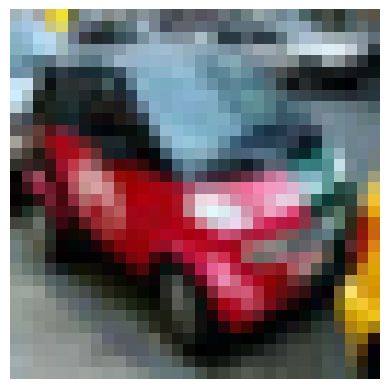

In [32]:
# fazer uma previsão utilizando um caso
def make_prediction(model, img): # img shape (784,1)
    img = img.reshape(1, 3, 32, 32) 
    print(img.shape)
    print(img.dtype) # if t is your tensor, else you use t.type() for the other two
    img = img.to(device)
    prediction = model(img).cpu().detach().numpy()[0].argmax()
    x_ext=list(dic_classes.keys())
    print(f"predict:{prediction} - {x_ext[prediction]}")
    img=img.cpu()
    plt.axis('off')
    plt.grid()
    plt.imshow(img[0].permute((2, 1, 0)))
    plt.show()

model= torch.load('CNNModel_cifar_3.pth',weights_only=False)
imagens, label = next(iter(test_dl))
make_prediction(model,imagens[3]) 

## Modelo MY_CNN_CIFAR, uma melhoria face aos modelos utilizados

In [33]:
BATCH_SIZE = 128
class MY_CNN_CIFAR(Module):
    def __init__(self):
        super(MY_CNN_CIFAR, self).__init__()
        self.layer1 = nn.Sequential(Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
                                    BatchNorm2d(32),
                                    ReLU(),
                                    MaxPool2d(kernel_size=2, stride=2)
                                    )
        self.layer2 = nn.Sequential(Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                                    BatchNorm2d(64),
                                    ReLU(),
                                    MaxPool2d(2)
                                    )
        self.fc1 = Linear(in_features=64*7*7, out_features=1024)
        self.drop1 = nn.Dropout2d(0.3)
        self.fc2 = Linear(in_features=1024, out_features=516)
        self.drop2 = nn.Dropout2d(0.3)
        self.fc3 = Linear(in_features=516, out_features=128)
        self.drop3 = nn.Dropout2d(0.3)
        self.fc4 = Linear(in_features=128, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop1(out)
        out = self.fc2(out)
        out = self.drop2(out)
        out = self.fc3(out)
        out = self.drop3(out)
        out = self.fc4(out)
        return out
    
model = MY_CNN_CIFAR()
print(summary(model, input_size=(BATCH_SIZE, 3,32,32), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
MY_CNN_CIFAR                             [128, 10]                 --
├─Sequential: 1-1                        [128, 32, 16, 16]         --
│    └─Conv2d: 2-1                       [128, 32, 32, 32]         896
│    └─BatchNorm2d: 2-2                  [128, 32, 32, 32]         64
│    └─ReLU: 2-3                         [128, 32, 32, 32]         --
│    └─MaxPool2d: 2-4                    [128, 32, 16, 16]         --
├─Sequential: 1-2                        [128, 64, 7, 7]           --
│    └─Conv2d: 2-5                       [128, 64, 14, 14]         18,496
│    └─BatchNorm2d: 2-6                  [128, 64, 14, 14]         128
│    └─ReLU: 2-7                         [128, 64, 14, 14]         --
│    └─MaxPool2d: 2-8                    [128, 64, 7, 7]           --
├─Linear: 1-3                            [128, 1024]               3,212,288
├─Dropout2d: 1-4                         [128, 1024]               --
├─

MY_CNN_CIFAR(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (drop1): Dropout2d(p=0.3, inplace=False)
  (fc2): Linear(in_features=1024, out_features=516, bias=True)
  (drop2): Dropout2d(p=0.3, inplace=False)
  (fc3): Linear(in_features=516, out_features=128, bias=True)
  (drop3): Dropout2d(p=0.3, inplace=False)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)

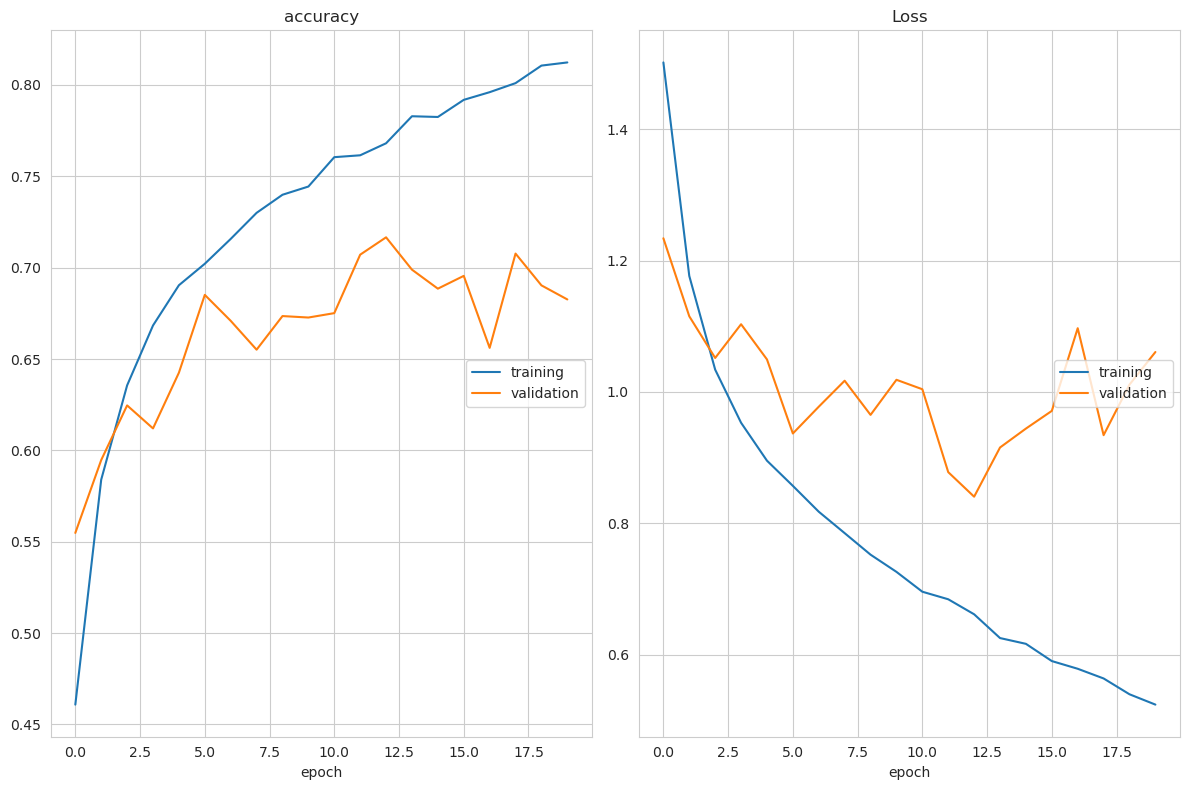

accuracy
	training         	 (min:    0.461, max:    0.812, cur:    0.812)
	validation       	 (min:    0.555, max:    0.717, cur:    0.683)
Loss
	training         	 (min:    0.524, max:    1.501, cur:    0.524)
	validation       	 (min:    0.841, max:    1.234, cur:    1.061)
Tempo gasto: 57.15058322199911 segundos


In [36]:
EPOCHS = 20
LEARNING_RATE = 0.0005
model = MY_CNN_CIFAR()
# batch size a 32
print(summary(model, input_size=(32, 3,32,32), verbose=0))
model.to(device)
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel_MY_CNN_CIFAR.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

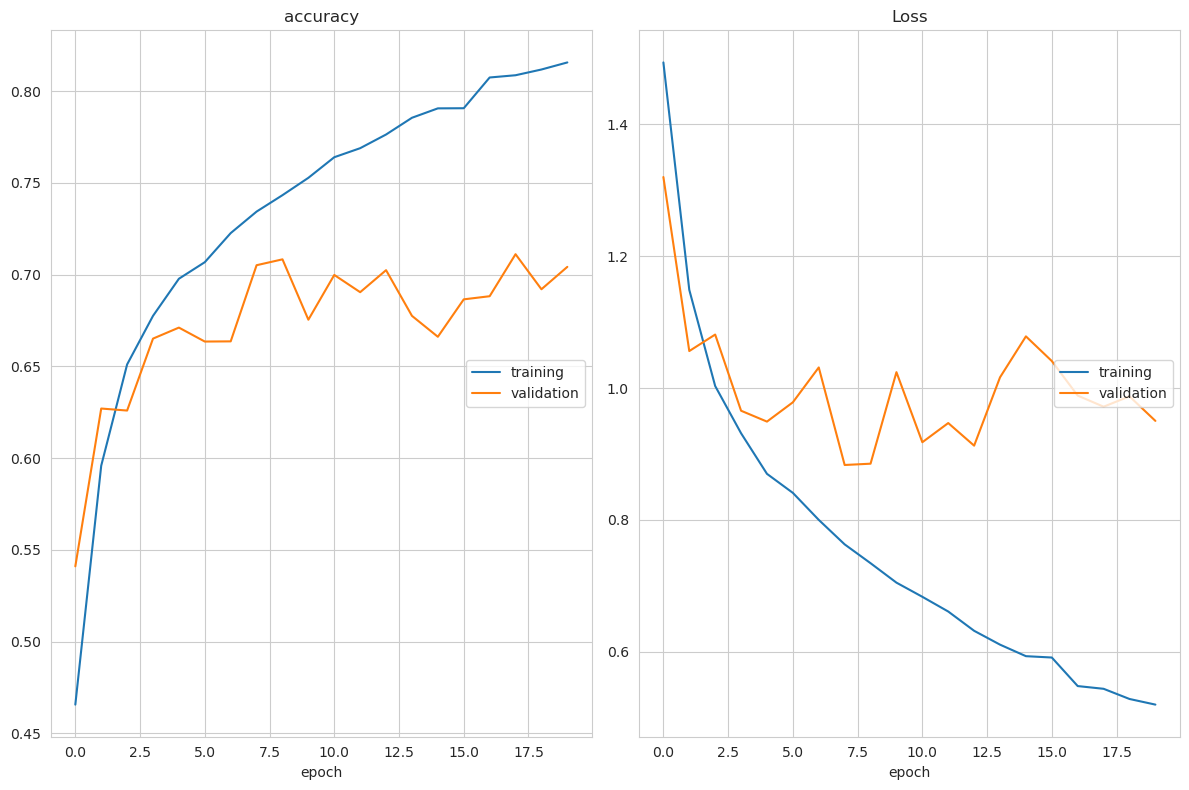

accuracy
	training         	 (min:    0.466, max:    0.816, cur:    0.816)
	validation       	 (min:    0.541, max:    0.711, cur:    0.704)
Loss
	training         	 (min:    0.520, max:    1.494, cur:    0.520)
	validation       	 (min:    0.883, max:    1.320, cur:    0.950)
Tempo gasto: 58.70531856600064 segundos


In [37]:
EPOCHS = 20
LEARNING_RATE = 0.0005
model = MY_CNN_CIFAR()
# batch size a 16
print(summary(model, input_size=(16, 3,32,32), verbose=0))
model.to(device)
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel_MY_CNN_CIFAR.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

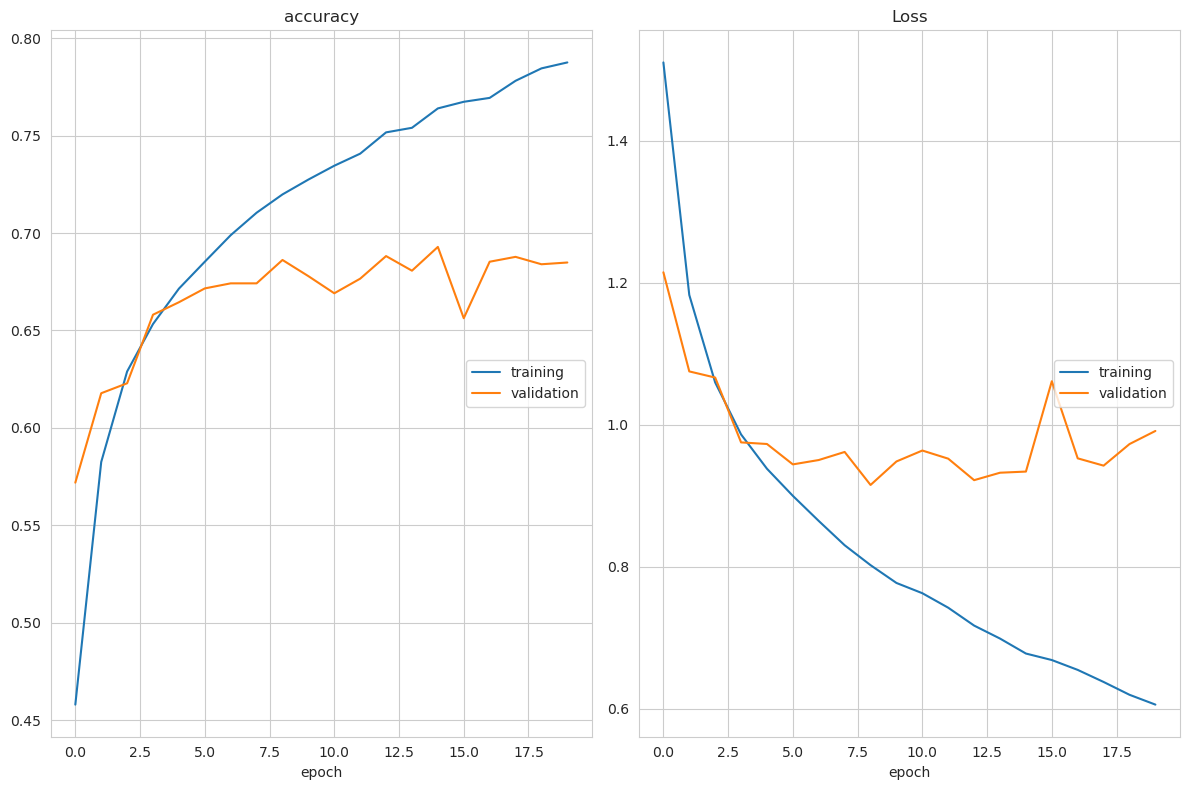

accuracy
	training         	 (min:    0.458, max:    0.788, cur:    0.788)
	validation       	 (min:    0.572, max:    0.693, cur:    0.685)
Loss
	training         	 (min:    0.606, max:    1.510, cur:    0.606)
	validation       	 (min:    0.915, max:    1.215, cur:    0.991)
Tempo gasto: 57.84257372000138 segundos


In [38]:
EPOCHS = 20
LEARNING_RATE = 0.0001
model = MY_CNN_CIFAR()
# batch size a 32
print(summary(model, input_size=(32, 3,32,32), verbose=0))
model.to(device)
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel_MY_CNN_CIFAR.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

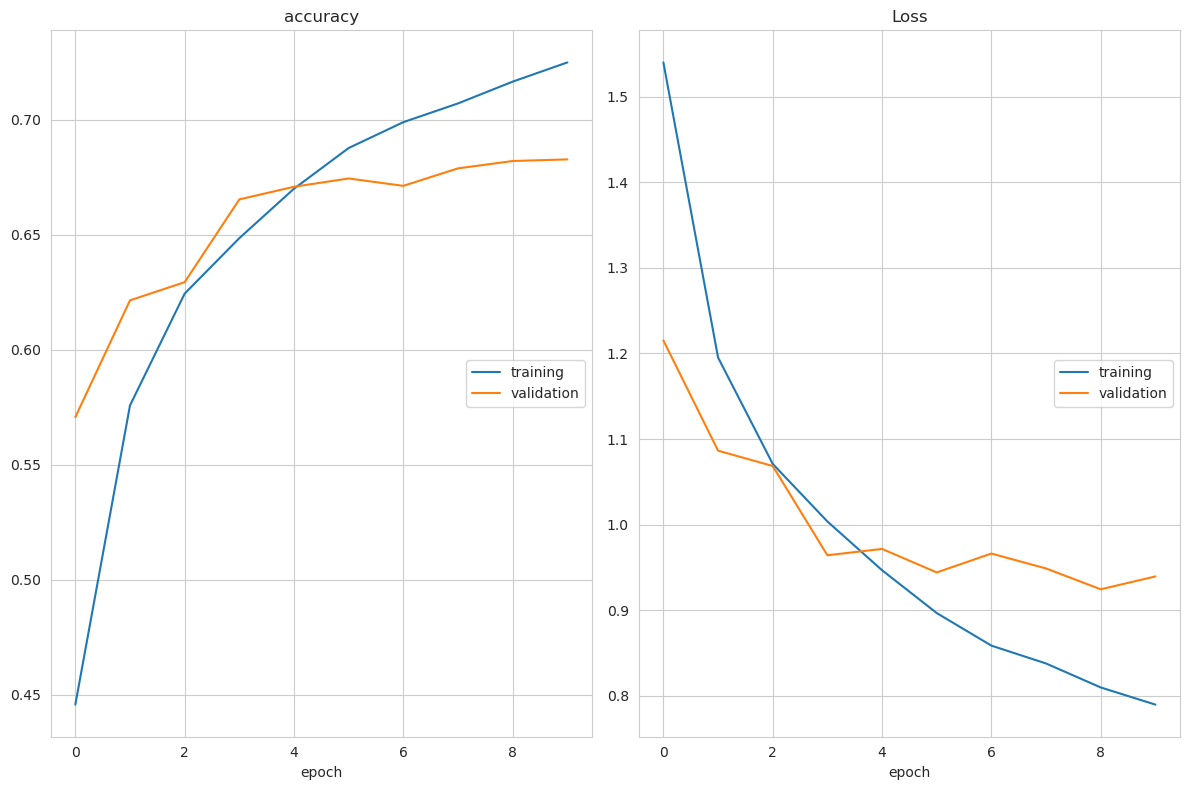

accuracy
	training         	 (min:    0.446, max:    0.725, cur:    0.725)
	validation       	 (min:    0.571, max:    0.683, cur:    0.683)
Loss
	training         	 (min:    0.790, max:    1.540, cur:    0.790)
	validation       	 (min:    0.925, max:    1.215, cur:    0.940)
Tempo gasto: 28.305680813002255 segundos


In [40]:
EPOCHS = 10
LEARNING_RATE = 0.0001
model = MY_CNN_CIFAR()
# batch size a 16
print(summary(model, input_size=(16, 3,32,32), verbose=0))
model.to(device)
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel_MY_CNN_CIFAR.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

### Conclusão
Considero que foi possível obter um modelo com um desempenho razoável. No entanto, é importante dizer que o processo de treino foi condicionado por limitações ao nível do poder computacional disponível. Estas restrições influenciaram não só o tempo necessário para treinar os modelos, mas também a possibilidade de explorar arquiteturas mais complexas ou realizar uma afinação mais exaustiva dos hiperparâmetros.

**Eduardo Cunha PG55939**